In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

from Area2_analysis.lr_funcs import angle_between, pred_with_new_weights
from Area2_analysis.lr_funcs import nans, fit_and_predict, gaussian_filter1d_oneside
from Area2_analysis.lr_funcs import sub_and_predict,calc_proj,get_sses_mean, get_sses_pred

from matplotlib.patches import Patch
import matplotlib
matplotlib.rc('font', size=18)

# import importlib
# import Area2_analysis.lr_funcs
# importlib.reload(Area2_analysis.lr_funcs)
# from Area2_analysis.lr_funcs import 

2024-08-07 16:08:36.481533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


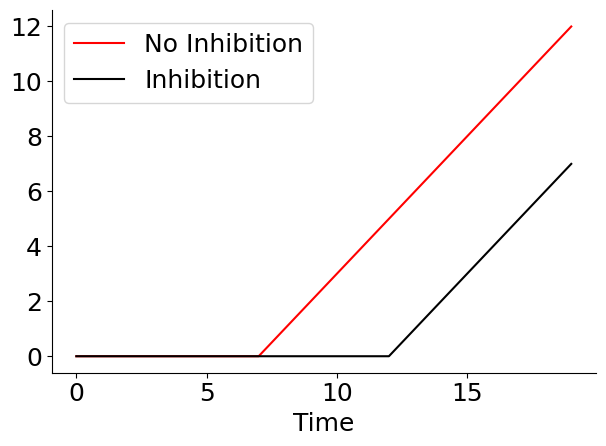

In [2]:
def relu(x):
    return np.maximum(0.0,x)
thresh = 7
x = np.array(range(20))
x_inh = relu(x-5)
y = relu(x-thresh)
y_inh = relu(x_inh - thresh)

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(y,color ='red')
plt.plot(y_inh,color ='k')
plt.xlabel('Time')
plt.legend(['No Inhibition','Inhibition'])
plt.tight_layout()
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
plt.savefig(figDir + 'relu.pdf', dpi = 'figure')
plt.show()

In [2]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Han_20171207"
filename = foldername + monkey + "_COactpas_TD.nwb"

dataset_5ms = NWBDataset(filename, split_heldout=False)
xy_vel = dataset_5ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_5ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [ ]:
# xyz_force = np.array([dataset_5ms.data['force']['x'].to_numpy(), dataset_5ms.data['force']['y'].to_numpy(), dataset_5ms.data['force']['z'].to_numpy()]).T
# dataset_5ms.add_continuous_data(xyz_force,'manip_force',chan_names = ['x','y','z'])

In [3]:
dataset_20ms = NWBDataset(filename, split_heldout=False)
xy_vel = dataset_20ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_20ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
# vel_acc = np.append(xy_vel, xy_acc, axis = 1)
# dataset_20ms.add_continuous_data(vel_acc,'vel_acc')
dataset_20ms.resample(20)
bin_width = dataset_20ms.bin_width
print(bin_width)

20


In [4]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
all_mask = (dataset_5ms.trial_info.split != 'none')

n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)

if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)

print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA_40')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

153 neurons
(558262, 153)
(558262, 20)
PCA total var explained: 0.3876050770392774


In [5]:
all_data = np.array(dataset_20ms.data.spikes)
print(all_data.shape)

if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)

print(PCA_data.shape)
dataset_20ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

(139566, 153)
(139566, 20)
PCA total var explained: 0.23821813378384826


In [ ]:
# gaussian_kernel_width = 20 #in ms
# sigma = int(gaussian_kernel_width/bin_width)
# data_smoothed = gaussian_filter1d_oneside(dataset_5ms.data.spikes.to_numpy().astype(np.float64),sigma,axis=0)
# dataset_5ms.add_continuous_data(data_smoothed,'spikes_smth_20_oneside')

# all_data = np.array(dataset_5ms.data.spikes_smth_20_oneside)
# print(all_data.shape)
# if not np.isnan(all_data).any():
#     scaler = StandardScaler()
#     X = scaler.fit_transform(all_data)
#     pca = PCA(n_components=n_dims,random_state = 42)
#     PCA_data = pca.fit_transform(X)
# print(PCA_data.shape)
# dataset_5ms.add_continuous_data(PCA_data,'PCA_20_oneside')
# print('PCA total var explained:',sum(pca.explained_variance_ratio_))

In [6]:
#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_5ms
trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == False) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == True) & \
           (dataset.trial_info['split'] != 'none'))[0])


active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

245 active trials
218 passive trials
[6. 4. 5. 4. 0. 2. 0. 5. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2.
 2. 7. 0. 4. 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2.
 1. 5. 1. 1. 1. 1. 1. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 6. 7. 2. 0. 0. 5. 7. 5. 1. 4. 2. 0. 0. 5.
 4. 6. 3. 6. 3. 6. 3. 1. 7. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5. 1.
 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0. 2.
 5. 1. 3. 0. 7. 2. 3. 1. 2. 2. 0. 4. 2. 1. 3. 5. 5. 2. 1. 4. 1. 1. 6. 4.
 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0. 0. 0. 3. 7.
 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4. 3. 3. 6. 1.
 0. 2. 0. 0. 3.]
245
[6. 3. 3. 2. 4. 0. 6. 1. 0. 3. 2. 7. 6. 6. 6. 5. 4. 5. 3. 0. 4. 1. 6. 6.
 1. 5. 1. 0. 7. 1. 4. 4. 7. 6. 7. 3. 3. 0. 3. 5. 6. 6. 3. 2. 1. 1. 4. 7.
 5. 4. 4. 4. 7. 4. 3. 0. 7. 0. 0. 0. 7. 2. 5. 3. 5. 2. 7. 2. 5. 7.

In [ ]:
# Heat map of how decoders at different lags work for each other
dataset = dataset_5ms
trial_mask = active_mask
x_field = 'PCA_40'
y_field = 'hand_acc'
lag_axis = np.arange(-200,201,20)
r2_map_array = nans([len(lag_axis),len(lag_axis)])
train_range = (-100, 500)

for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2,weights,_ = fit_and_predict(dataset, trial_mask, 'move_onset_time', train_range, lag, x_field, y_field)
    train_lag_range = (train_range[0]+lag, train_range[1]+lag)
    for j in range(len(lag_axis)):
        lag = lag_axis[j]
        r2,_,_,_,_ = pred_with_new_weights(dataset, trial_mask, 'move_onset_time',train_range, lag,
                                           x_field,y_field, weights, train_range, train_lag_range, trial_mask)
        r2_map_array[i][j] = r2

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
vmin = r2_map_array.min()
vmax = r2_map_array.max()
from matplotlib import colors
norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

im = plt.imshow(r2_map_array, origin='lower', cmap='RdBu_r', norm=norm)
plt.colorbar()
ax.set_xlabel('Predicting time lag (ms)')
ax.set_ylabel('Training time lag (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.flip(np.arange(len(lag_axis))))
ax.set_xticklabels(labels=lag_axis,fontsize=12)
ax.set_yticklabels(labels=np.flip(lag_axis),fontsize=12)

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(r2_map_array[i, j]*100)/100),
                        ha="center", va="center", color="w", fontsize=10)
plt.tight_layout()

In [ ]:
idx = np.argwhere(lag_axis==-60)[0,0]
auto = r2_map_array[idx]
diag = r2_map_array[range(len(lag_axis)), range(len(lag_axis))]
plt.plot(lag_axis, diag, label = 'Original')
diag_corr = diag - auto * (auto>0)
plt.plot(lag_axis, diag_corr, label = 'Corrected')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.legend()
plt.axvline(lag_axis[np.argwhere(lag_axis== 0)], color = 'k', linestyle='--')

In [33]:
# decoders angle
dataset = dataset_5ms
x_field = 'PCA_40'
y_field ='hand_acc'

dim = n_dims 
act_lag_axis = np.arange(-200,201,20)
pas_lag_axis = np.arange(-200,201,20)

act_coef_array = nans([len(act_lag_axis),2,dim])
pas_coef_array = nans([len(pas_lag_axis),2,dim])

trial_mask = passive_mask
cond_dict = passive_cond_dict
for i in range(len(act_lag_axis)):
    lag = act_lag_axis[i]
    _, coef, _, _ = fit_and_predict(dataset, trial_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field, cond_dict)
    act_coef_array[i,:,:] = coef

# trial_mask = active_mask
# cond_dict = active_cond_dict
trial_mask = passive_mask
cond_dict = passive_cond_dict
for i in range(len(pas_lag_axis)):
    lag = pas_lag_axis[i]
    _, coef, _,_ = fit_and_predict(dataset, trial_mask, 'move_onset_time', (200, 500), lag, x_field, y_field, cond_dict)
    pas_coef_array[i,:,:] = coef


act_t_label = act_lag_axis
pas_t_label = pas_lag_axis
act_X_coef_array = act_coef_array[:,0,:]
pas_X_coef_array = pas_coef_array[:,0,:]
angDist_array = nans([len(act_t_label),len(pas_t_label)])

for i in range(len(act_t_label)):
    for j in range(len(pas_t_label)):
        angDist_array[i,j] = math.degrees(angle_between(act_X_coef_array[i,:],pas_X_coef_array[j,:]))
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(angDist_array)
ax.set_xlabel('Passive lag time (ms)')
# ax.set_xlabel('Active lag time (ms)')
ax.set_ylabel('Passive lag time (ms)')

ax.set_xticks(np.arange(len(pas_t_label)))
ax.set_yticks(np.arange(len(act_t_label)))
ax.set_xticklabels(labels=pas_t_label)
ax.set_yticklabels(labels=act_t_label)

ax.set_title("Angle between decoder weights")

for i in range(len(act_t_label)):
    for j in range(len(pas_t_label)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
# figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
# plt.savefig(figDir + monkey + '_decoder_angle.pdf', dpi = 'figure')
plt.show()

KeyboardInterrupt: 

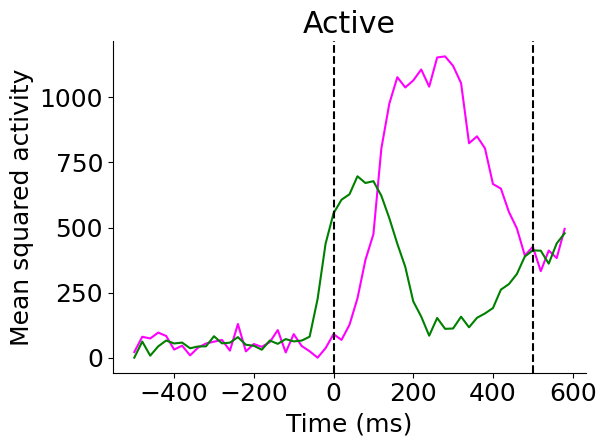

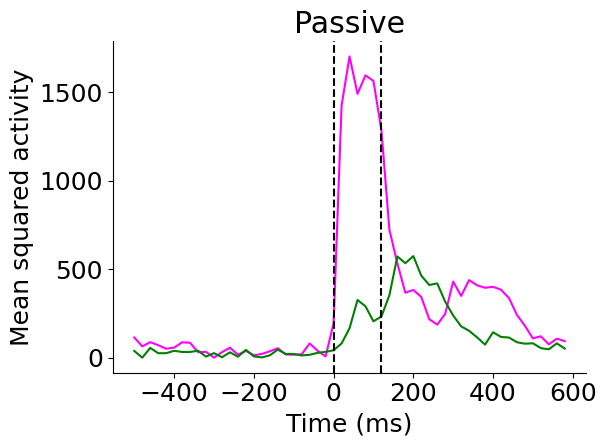

In [68]:
# # Variance at each timepoint (across trials) on decoding axes
# dataset = dataset_20ms
# x_field = 'spikes'
# y_field = 'hand_vel'
# dim = n_neurons

dataset = dataset_20ms
x_field = 'spikes'
y_field = 'hand_vel'
dim = n_neurons

negative_lag = -180
positive_lag = 0
fit_range = (-100, 1000)

_, aff_weights, _,_ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, positive_lag, x_field, y_field)
_, eff_weights, _,_ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, negative_lag,x_field,y_field)

# _, eff_weights, _,_ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, negative_lag, x_field, y_field)
# _, aff_weights, _,_ = sub_and_predict(dataset, active_mask, 'move_onset_time', fit_range, positive_lag,x_field,y_field,eff_weights)

# _, aff_weights, _,_ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, positive_lag, x_field, y_field)
# _, eff_weights, _,_ = sub_and_predict(dataset, active_mask, 'move_onset_time', fit_range, negative_lag,x_field,y_field,aff_weights)

pred_range = (-500,600)
passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~passive_mask)
active_df = dataset.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~active_mask)

#plot Active var
n_trials = dataset.trial_info.loc[active_mask].shape[0]
n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

# aff_proj = pca.inverse_transform(calc_proj(active_df[x_field].to_numpy(),aff_weights.T).T.reshape(-1,n_dims)).reshape(n_trials, n_timepoints,n_neurons)
aff_proj = calc_proj(active_df[x_field].to_numpy(),aff_weights.T).T.reshape(n_trials, n_timepoints,dim)
aff_var = nans([n_timepoints])
for i in range(n_timepoints):
    # var = np.sum(get_sses_mean(aff_proj[:,i,:]))
    var = np.sum(np.square(aff_proj[:,i,:]))
    aff_var[i] = var
aff_var = aff_var - np.min(aff_var)

# eff_proj = pca.inverse_transform(calc_proj(active_df[x_field].to_numpy(),eff_weights.T).T.reshape(-1,n_dims)).reshape(n_trials, n_timepoints,n_neurons)
eff_proj = calc_proj(active_df[x_field].to_numpy(),eff_weights.T).T.reshape(n_trials, n_timepoints,dim)
eff_var = nans([n_timepoints])
for i in range(n_timepoints):
    # var = np.sum(get_sses_mean(eff_proj[:,i,:]))
    var = np.sum(np.square(eff_proj[:,i,:])) 
    eff_var[i] = var
eff_var = eff_var - np.min(eff_var)

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(x_axis, aff_var,color = 'magenta',label = 'Aff')
plt.plot(x_axis, eff_var,color = 'green',label = 'Eff')
# plt.plot(x_axis, aff_var_explained + eff_var_explained,color = 'red',label = 'Sum')
plt.axvline(0, color = 'k',linestyle = '--')
plt.axvline(500, color = 'k',linestyle = '--')
# plt.xlim([-500,600])
plt.xlabel('Time (ms)')
plt.ylabel('Mean squared activity')
plt.title('Active')
# plt.legend()
plt.tight_layout()
figDir = '/Users/sherryan/area2_population_analysis/'
plt.savefig(figDir + monkey + '_vel_var_act.pdf', dpi = 'figure')
plt.show()

#plot Passive var
n_trials = dataset.trial_info.loc[passive_mask].shape[0]
# aff_proj = pca.inverse_transform(calc_proj(passive_df[x_field].to_numpy(),aff_weights.T).T.reshape(-1,n_dims)).reshape(n_trials, n_timepoints,n_neurons)
aff_proj = calc_proj(passive_df[x_field].to_numpy(),aff_weights.T).T.reshape(n_trials, n_timepoints,dim)
aff_var = nans([n_timepoints])
for i in range(n_timepoints):
    # var = np.sum(get_sses_mean(aff_proj[:,i,:]))
    var = np.sum(np.square(aff_proj[:,i,:]))
    aff_var[i] = var
aff_var = aff_var - np.min(aff_var)

# eff_proj = pca.inverse_transform(calc_proj(passive_df[x_field].to_numpy(),eff_weights.T).T.reshape(-1,n_dims)).reshape(n_trials, n_timepoints,n_neurons)
eff_proj = calc_proj(passive_df[x_field].to_numpy(),eff_weights.T).T.reshape(n_trials, n_timepoints,dim)
eff_var = nans([n_timepoints])
for i in range(n_timepoints):
    # var = np.sum(get_sses_mean(eff_proj[:,i,:]))
    var = np.sum(np.square(eff_proj[:,i,:])) 
    eff_var[i] = var
eff_var = eff_var - np.min(eff_var)

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(x_axis, aff_var,color = 'magenta',label = 'Aff')
plt.plot(x_axis, eff_var,color = 'green',label = 'Eff')
plt.title('Passive')
# plt.plot(x_axis, aff_var_explained + eff_var_explained,color = 'red',label = 'Sum')
plt.axvline(0, color = 'k',linestyle = '--')
plt.axvline(120, color = 'k',linestyle = '--')
# plt.axvline(180, color = 'k',linestyle = '--')
# plt.axvline(500, color = 'k',linestyle = '--')
# plt.xlim([-500,600])
plt.xlabel('Time (ms)')
plt.ylabel('Mean squared activity')
# plt.title('')
# plt.legend()
plt.tight_layout()
figDir = '/Users/sherryan/area2_population_analysis/'
plt.savefig(figDir + monkey + '_vel_var_pas.pdf', dpi = 'figure')
plt.show()

best lag of aligning passive afferent prediction is -20


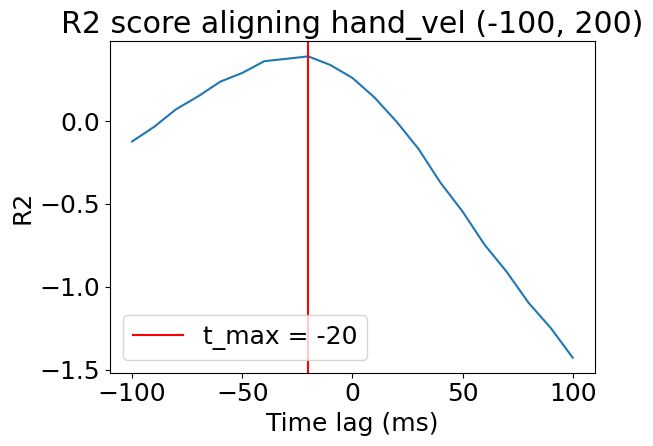

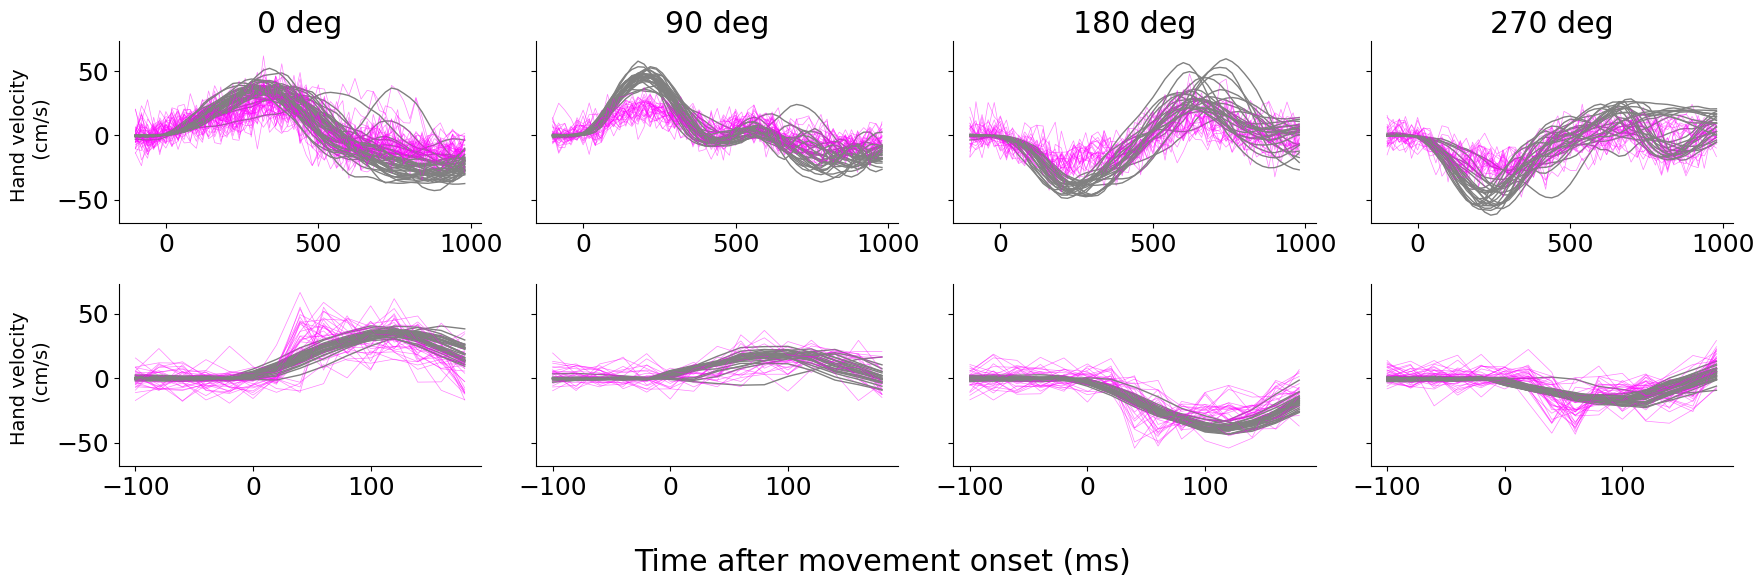

In [12]:
# Cross-decoding

dataset = dataset_20ms
all_mask = dataset.trial_info.split != 'none'


positive_lag = 0
negative_lag = -180

x_field = 'spikes'
y_field ='hand_vel'
train_range = (-100,1000)
train_pos_lag_range = (train_range[0]+positive_lag, train_range[1]+positive_lag)
train_neg_lag_range = (train_range[0]+negative_lag, train_range[1]+negative_lag)
train_mask = active_mask

_, aff_weights, aff_offset, _ = fit_and_predict(dataset, train_mask, 'move_onset_time', train_range, positive_lag, x_field, y_field)
# _, eff_weights, _ = sub_and_predict(dataset, train_mask, 'move_onset_time', train_range, negative_lag,x_field,y_field,aff_weights)
_, eff_weights, eff_offset, _ = fit_and_predict(dataset, train_mask, 'move_onset_time', train_range, negative_lag,x_field,y_field)


# _, eff_weights, eff_offset, _ = fit_and_predict(dataset, active_mask, 'move_onset_time', train_range, negative_lag, x_field, y_field)
# _, aff_weights, aff_offset,_ = sub_and_predict(dataset, active_mask, 'move_onset_time', train_range, positive_lag,x_field,y_field,eff_weights)

# _, aff_weights, _ = fit_and_predict(dataset, passive_mask, 'move_onset_time', (-100, 120), positive_lag,x_field,y_field)

#pred active
pred_range = (-100,1000)
active_x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
_, _, _,_,act_aff_vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range, positive_lag,x_field,
                                                 y_field, aff_weights, aff_offset, train_range, train_pos_lag_range, train_mask)
_, _, _,_,act_eff_vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range, negative_lag,x_field,
                                                 y_field, eff_weights, eff_offset, train_range, train_neg_lag_range, train_mask)

#pred passive
pred_range = (-100, 200)
passive_x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
_, _, _,_,pas_aff_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, positive_lag,x_field,
                                                 y_field, aff_weights, aff_offset, train_range, train_pos_lag_range, train_mask)
_, _, _,_,pas_eff_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, negative_lag,x_field,
                                                 y_field, eff_weights, eff_offset, train_range, train_neg_lag_range, train_mask)

# find best lag in aligning passive component
pred_range = (-100,200)
lag_axis = np.arange(-100,101,10)
curr_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, _, _,_,_ = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, aff_weights,aff_offset,
                                     train_range, train_pos_lag_range, train_mask)
    curr_r2_array[i] = r2
best_lag = lag_axis[np.argmax(curr_r2_array)]
print('best lag of aligning passive afferent prediction is', best_lag)
_, _, _,_,pas_aff_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, best_lag,x_field,y_field, aff_weights,aff_offset,
                                             train_range, train_pos_lag_range, train_mask)

plt.plot(lag_axis, curr_r2_array)
plt.axvline(best_lag, color = 'r', label='t_max = ' + str(best_lag))
plt.legend()
plt.title('R2 score aligning ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.show()

# # find best lag in aligning active trials
# pred_range = (-100, 500)
# lag_axis = np.arange(-100,151,10)
# curr_r2_array = nans([len(lag_axis)])
# for i in range(len(lag_axis)):
#     lag = lag_axis[i]
#     r2, _, _ = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range, lag,x_field,y_field, aff_weights)
#     curr_r2_array[i] = r2
# best_lag = lag_axis[np.argmax(curr_r2_array)]
# print('best lag of aligning active prediction is', best_lag)

# plt.plot(lag_axis, curr_r2_array)
# plt.axvline(best_lag, color = 'r', label='t_max = ' + str(best_lag))
# plt.legend()
# plt.title('R2 score aligning ' + y_field + ' ' + str(pred_range))
# plt.xlabel('Time lag (ms)')
# plt.ylabel('R2')
# plt.tight_layout()
# plt.show()
# _, _, act_aff_vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range, best_lag,x_field,y_field, aff_weights)

plot_dir = [0.0, 180.0] # limit plot directions to reduce cluttering
colors = ['gray','gray']
plot_dim = 'x'
fig, axs = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(18, 6))
i = 0
alpha = 0.5
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_aff_vel_df[np.isin(act_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][i].plot(active_x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = alpha, linewidth=0.5)
    # for _, trial in act_eff_vel_df[np.isin(act_eff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
    #     axs[0][i].plot(active_x_axis, trial.pred_vel[plot_dim], color='green', alpha = alpha, linewidth=0.5)
        axs[0][i].plot(active_x_axis, trial[y_field][plot_dim], color=color, linewidth=1)
        axs[0][i].spines[['right', 'top']].set_visible(False) 
    for _, trial in pas_aff_vel_df[np.isin(pas_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[1][i].plot(passive_x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = alpha, linewidth=0.5)  
    # for _, trial in pas_eff_vel_df[np.isin(pas_eff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
    #     axs[1][i].plot(passive_x_axis, trial.pred_vel[plot_dim], color='green', alpha = alpha, linewidth=0.5)
        axs[1][i].plot(passive_x_axis, trial[y_field][plot_dim], color=color, linewidth=1)
        axs[1][i].spines[['right', 'top']].set_visible(False)
    i+=2
plot_dir = [90.0, 270.0] # limit plot directions to reduce cluttering
colors = ['gray', 'gray']
plot_dim = 'y'
i = 1
alpha = 0.5
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_aff_vel_df[np.isin(act_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][i].plot(active_x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = alpha, linewidth=0.5)
    # for _, trial in act_eff_vel_df[np.isin(act_eff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
    #     axs[0][i].plot(active_x_axis, trial.pred_vel[plot_dim], color='green', alpha = alpha, linewidth=0.5)
        axs[0][i].plot(active_x_axis, trial[y_field][plot_dim], color=color, linewidth=1)
        axs[0][i].spines[['right', 'top']].set_visible(False) 
    for _, trial in pas_aff_vel_df[np.isin(pas_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[1][i].plot(passive_x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = alpha, linewidth=0.5)
    # for _, trial in pas_eff_vel_df[np.isin(pas_eff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
    #     axs[1][i].plot(passive_x_axis, trial.pred_vel[plot_dim], color='green', alpha = alpha, linewidth=0.5)
        axs[1][i].plot(passive_x_axis, trial[y_field][plot_dim], color=color, linewidth=1)
        axs[1][i].spines[['right', 'top']].set_visible(False)
    i+=2

fig.supxlabel('Time after movement onset (ms)')
# axs[0][0].set_ylabel('Prediction',fontsize=14)
# axs[1][0].set_ylabel('Prediction',fontsize=14)
# axs[0][0].set_ylabel('Hand acceleration \n (cm/s^2)',fontsize=14)
# axs[1][0].set_ylabel('Hand acceleration \n (cm/s^2)',fontsize=14)
axs[0][0].set_ylabel('Hand velocity \n (cm/s)',fontsize=14)
axs[1][0].set_ylabel('Hand velocity \n (cm/s)',fontsize=14)


axs[0][0].set_title('0 deg')
axs[0][1].set_title('90 deg')
axs[0][2].set_title('180 deg')
axs[0][3].set_title('270 deg')


# legend_elements = [Patch(facecolor='magenta', label='Afferent prediction'),
#                     Patch(facecolor='k', label='Efferent prediction')]
# legend_elements = [Patch(facecolor='magenta', label='Afferent prediction')]
# plt.legend(handles=legend_elements)
plt.tight_layout()
figDir = '/Users/sherryan/area2_population_analysis/'
plt.savefig(figDir + monkey + '_cross_vel_both_early_aligned.pdf', dpi = 'figure')
plt.show()

In [ ]:
# # 2D plot

dataset = dataset_5ms
x_field = 'PCA_40'
y_field ='hand_acc'

plot_dir = 0.0
plot_dim = 'x'
putative_aff_lag = 80
putative_eff_lag = -60
fit_range = (-100,500)
dim = n_dims
all_mask = dataset_5ms.trial_info.split != 'none'

aff_fit_mask = active_mask
eff_fit_mask = active_mask

# _, aff_axis, _ = fit_and_predict(dataset, aff_fit_mask, 'move_onset_time', fit_range, putative_aff_lag, x_field, y_field)
# _, eff_axis,_ = sub_and_predict(dataset, eff_fit_mask, 'move_onset_time', fit_range, putative_eff_lag,x_field,y_field,aff_axis)
# _, eff_axis,_ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, putative_eff_lag,x_field,y_field, cond_dict = cond_dict)

_, eff_axis, _ = fit_and_predict(dataset, eff_fit_mask, 'move_onset_time', fit_range, putative_eff_lag, x_field, y_field)
_, aff_axis,_ = sub_and_predict(dataset, aff_fit_mask, 'move_onset_time', fit_range, putative_aff_lag,x_field,y_field,eff_axis)

print(math.degrees(angle_between(aff_axis[0,:],eff_axis[0,:])))

pred_range =(-1000,700)
x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

if plot_dim == 'x':
    aff_axis_x = aff_axis[0,:]
    eff_axis_x = eff_axis[0,:]
if plot_dim == 'y':
    aff_axis_x = aff_axis[1,:]
    eff_axis_x = eff_axis[1,:]

fig, ax = plt.subplots()
# fig.set_figheight(4)
plt.xlabel('Aff axis')
plt.ylabel('Eff axis')
plt.title('')
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_aspect('equal')
ax.set_xticks([]); ax.set_yticks([])
ax.yaxis.set_label_coords(-.1, .9)
ax.xaxis.set_label_coords(.9, -.1)

# # Define Passive
# trial_mask = (dataset_5ms.trial_info.cond_dir == plot_dir) & (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
# df = dataset.make_trial_data(align_field= 'move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
# n_trials = dataset.trial_info.loc[trial_mask].shape[0]
# n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
# pas_aff_proj = np.mean((df[x_field].to_numpy()@aff_axis_x.T).reshape(n_trials, n_timepoints),axis=0)
# pas_eff_proj = np.mean((df[x_field].to_numpy()@eff_axis_x.T).reshape(n_trials, n_timepoints),axis=0)

# ## Plot Passive (1)
# # plt.plot(pas_aff_proj, pas_eff_proj, color = 'k', label = 'Passive proj')
# plt.scatter(pas_aff_proj,pas_eff_proj,s = 10,c=x_axis, cmap='Greys')
# plt.scatter(pas_aff_proj[np.argwhere(x_axis==0)],pas_eff_proj[np.argwhere(x_axis==0)],color = 'green',zorder=10)
# plt.scatter(pas_aff_proj[np.argwhere(x_axis==120)],pas_eff_proj[np.argwhere(x_axis==120)],color = 'red',zorder=10)
# plt.scatter(pas_aff_proj[np.argwhere(x_axis==500)],pas_eff_proj[np.argwhere(x_axis==500)],color = 'orange',zorder=10)


## Define Active
trial_mask = (dataset_5ms.trial_info.cond_dir == plot_dir) & (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
df = dataset.make_trial_data(align_field= 'move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
act_aff_proj = np.mean((df[x_field].to_numpy() @ aff_axis_x.T).reshape(n_trials, n_timepoints),axis=0)
act_eff_proj = np.mean((df[x_field].to_numpy() @ eff_axis_x.T).reshape(n_trials, n_timepoints),axis=0)

## Plot Active (1)
# plt.plot(act_aff_proj, act_eff_proj, color = 'blue', label = 'Active proj')
plt.scatter(act_aff_proj,act_eff_proj,s = 10,c=x_axis, cmap='Blues')
plt.scatter(act_aff_proj[np.argwhere(x_axis==0)],act_eff_proj[np.argwhere(x_axis==0)],color = 'green',zorder=10)
plt.scatter(act_aff_proj[np.argwhere(x_axis==120)],act_eff_proj[np.argwhere(x_axis==120)],color = 'red',zorder=10)
plt.scatter(act_aff_proj[np.argwhere(x_axis==500)],act_eff_proj[np.argwhere(x_axis==500)],color = 'orange',zorder=10)
plt.scatter(act_aff_proj[np.argwhere(x_axis==1000)],act_eff_proj[np.argwhere(x_axis==1000)],color = 'orange',zorder=10)


legend_elements = [Patch(facecolor='#1f77b4', label='Active'),
                    Patch(facecolor='#7f7f7f', label='Passive')]
# plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

In [ ]:
# # 1D plot
dataset = dataset_5ms
x_field = 'PCA_40'
y_field ='hand_acc'

plot_dir = 0.0
plot_dim = 'x'
proj_axis = 'Efferent'

pred_range =(-1000,1000)
putative_aff_lag = 80
putative_eff_lag = -60
aff_fit_mask = active_mask 
eff_fit_mask = active_mask 
aff_fit_range = (-100, 500)
eff_fit_range = (-100, 500)

if proj_axis == 'Efferent':
    _, eff_axis, _ = fit_and_predict(dataset, eff_fit_mask, 'move_onset_time', eff_fit_range, putative_eff_lag, x_field, y_field)
    if plot_dim == 'x':
        axis = eff_axis[0,:]    
    if plot_dim == 'y':
        axis = eff_axis[1,:]
if proj_axis == 'Afferent':
    _, eff_axis, _ = fit_and_predict(dataset, eff_fit_mask, 'move_onset_time', eff_fit_range, putative_eff_lag, x_field, y_field)
    _, aff_axis,_ = sub_and_predict(dataset, aff_fit_mask, 'move_onset_time', aff_fit_range, putative_aff_lag,x_field,y_field,eff_axis)
    if plot_dim == 'x':
        axis = aff_axis[0,:]    
    if plot_dim == 'y':
        axis = aff_axis[1,:]

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

trial_mask = (dataset_5ms.trial_info.cond_dir == plot_dir) & (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
df = dataset.make_trial_data(align_field= 'move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
proj = (df[x_field].to_numpy()@ axis.T)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
proj_reshaped = proj.reshape(n_trials, n_timepoints)
mean_proj = np.mean(proj_reshaped,axis = 0)
fig, ax = plt.subplots()
fig.set_figheight(4)
plt.plot(mean_proj,x_axis,label = 'Active')
acc = (df[y_field][plot_dim].to_numpy()).reshape(n_trials,n_timepoints)
mean_acc = np.mean(acc/np.std(acc)-np.mean(acc),axis=0)

plt.plot(mean_acc,x_axis, color = '#1f77b4',alpha = 0.3)
plt.xlabel(f'{proj_axis} axis')
plt.title('')
plt.scatter(mean_proj,x_axis,s = 10)
plt.scatter(mean_proj[np.argwhere(x_axis==0)],0,color = 'green',zorder=10)
plt.scatter(mean_proj[np.argwhere(x_axis==120)],120,color = 'red',zorder=10)

trial_mask = (dataset_5ms.trial_info.cond_dir == plot_dir) & (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
df = dataset.make_trial_data(align_field= 'move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
proj = (df[x_field].to_numpy()@ axis.T)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
proj_reshaped = proj.reshape(n_trials, n_timepoints)
mean_proj = np.mean(proj_reshaped,axis = 0)
plt.plot(mean_proj,x_axis,color = 'k',label = 'Passive')
acc = (df[y_field][plot_dim].to_numpy()).reshape(n_trials,n_timepoints)
mean_acc = np.mean(acc/np.std(acc)-np.mean(acc),axis=0)

plt.plot(mean_acc,x_axis, color = 'k',alpha = 0.3)
plt.xlabel(f'{proj_axis} axis')
plt.yticks([])
plt.scatter(mean_proj,x_axis,s = 10,color = 'k')
plt.scatter(mean_proj[np.argwhere(x_axis==0)],0,color = 'green',zorder=10)
plt.scatter(mean_proj[np.argwhere(x_axis==120)],120,color = 'red',zorder=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend()